In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout import *
from kid_readout.roach import attenuator

In [3]:
ri = roach.r2heterodyne.Roach2Heterodyne(roachip='r2kid',attenuator=attenuator.Attenuator(),adc_valon='/dev/ttyUSB4',lo_valon='/dev/ttyUSB3',initialize=False)

In [4]:
ri.initialize()

Loaded ROACH state from /data/readout/r2kid_config.npz
ROACH configuration does not match saved state
Reinitializing system
Deprogramming
Programming r2iq2xpfb14mcr12gb_2016_Feb_20_0948.bof
Requested sampling rate 512.0 MHz. Estimated sampling rate 513.0 MHz
--- === Trying with OUT DELAYS to 29 === ---
Eye for QDR qdr0 (0 is pass, 1 is fail):
	Tap step  0:  11111111111111111111111111111111
	Tap step  1:  11111111111111110111110111110101
	Tap step  2:  11111111111111010100000101000101
	Tap step  3:  11111111111111000000000100000000
	Tap step  4:  01011001011111000000000000000000
	Tap step  5:  01000001000001000000000000000000
	Tap step  6:  00000000000000000000000000000000
	Tap step  7:  00000000000000000000000000000000
	Tap step  8:  00000000000000000000000000000000
	Tap step  9:  00000000000000000000000000000000
	Tap step 10:  00000000000000000000000000000000
	Tap step 11:  00000000000000000000000000000000
	Tap step 12:  00000000000000000000000000000000
	Tap step 13:  0000000000000000

In [5]:
ri.set_dac_atten(20)

In [6]:
low_group = np.array([ 1119.07673511,  1126.0153982 ,  1133.70131753,  1135.31245427,
        1143.21576741,  1148.0169738 ,  1159.41786884,  1160.26943775, 1162.33,
        1176.56747357,  1177.70848608,  1181.33728799,  1186.05472363,
        1190.29108718,  1193.62180971,  1203.87755917,  1205.8392229 ,
        1207.88046178,  1220.05286255,  1221.41371349,  1235.26613658, 1243.71])

to_add = 32 - len(low_group)
low_group = np.hstack((low_group,np.arange(to_add)+low_group.max()+2.))
low_group_lo = 1110.0

high_group = np.array([1576.67969747,  1599.40494104,  1605.60503541,
        1609.7742154 ,
        1623.02,
                       1628.5448411 ,  1648.17537644,  1649.22774551,
        1650.36575278,  1662.37845567,  1664.1706628 ,  1681.28526333,
        1682.17350834,  1684.44471064,  1702.0820426 ,  1706.79635917,
        1714.66047719,
                       1720.7, 1724.39938475,  1752.05587464,  1767.515093])

to_add = 32 - len(high_group)
high_group = np.hstack((high_group,np.arange(to_add)+high_group.max()+2.))
high_group_lo = 1570.0

nsamp = 2**18
step = 1
nstep = 16
offset_bins = np.arange(-(nstep + 1), (nstep + 1)) * step
offsets = offset_bins * 512.0 / nsamp

In [7]:
ri.set_lo(low_group_lo)

In [8]:
offsets

array([-0.03320312, -0.03125   , -0.02929688, -0.02734375, -0.02539062,
       -0.0234375 , -0.02148438, -0.01953125, -0.01757812, -0.015625  ,
       -0.01367188, -0.01171875, -0.00976562, -0.0078125 , -0.00585938,
       -0.00390625, -0.00195312,  0.        ,  0.00195312,  0.00390625,
        0.00585938,  0.0078125 ,  0.00976562,  0.01171875,  0.01367188,
        0.015625  ,  0.01757812,  0.01953125,  0.02148438,  0.0234375 ,
        0.02539062,  0.02734375,  0.02929688,  0.03125   ])

In [8]:
ri.blocks_per_second

TypeError: object of type 'NoneType' has no len()

In [9]:
(512e6/2**14.)/256.

122.0703125

In [10]:
122*(256/32.)

976.0

In [11]:
3906*256/32.

31248.0

In [12]:
np.add.outer(offsets,low_group).shape

(34, 32)

In [9]:
from kid_readout.measurement import basic,core

In [44]:
def run_sweep(ri, tone_banks, num_tone_samples, length_seconds=1, state=None, description='', **kwargs):
    stream_arrays = core.MeasurementList()
    for n, tone_bank in enumerate(tone_banks):
        #ri.phases=None
        ri.set_tone_freqs(tone_bank, nsamp=num_tone_samples)
        ri.select_fft_bins(np.arange(tone_bank.size))
        ri._sync()
        
        stream_arrays.append(ri.get_measurement(num_seconds=length_seconds, **kwargs))
    return basic.SweepArray(stream_arrays, state=state, description=description)

In [45]:
swa = run_sweep(ri,np.add.outer(offsets,low_group),nsamp,length_seconds=.2)

got bad packet
got weird packet (113,)


In [23]:
swp = swa.sweep(15)

In [51]:
swp.streams[0].s21_raw.shape

(8192,)

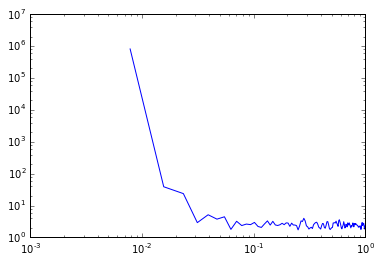

In [24]:
pxx,fr = mlab.psd(swp.streams[16].s21_raw)
loglog(fr,pxx)

In [53]:
ri.boffile

'r2iq2xpfb14mcr12gb_2016_Feb_20_0948.bof'

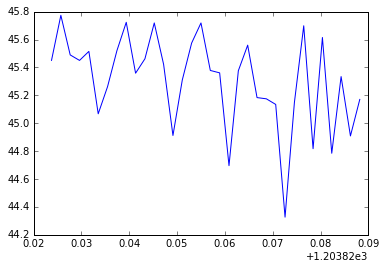

In [25]:
plot(swp.frequency_MHz_stack,20*np.log10(np.abs(swp.s21_points)))

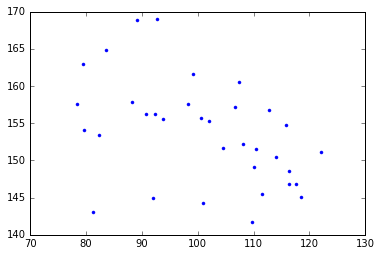

In [26]:
plot_ri(swp.s21_points,'.')

In [119]:
meas = ri.get_measurement(.2)

In [41]:
meas2 = ri.get_measurement(.2)

In [46]:
meas3 = ri.get_measurement(.2)

In [28]:
meas.s21_raw.shape

(32, 8192)

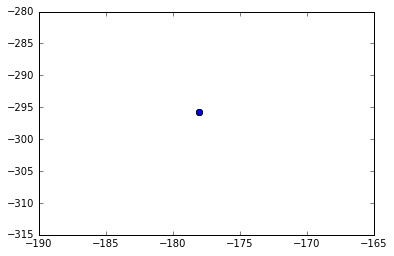

In [110]:
for k in range(8):
    #ri.phases=None
    ri.set_tone_freqs(low_group+1,nsamp=nsamp)
    ri.set_tone_freqs(low_group,nsamp=nsamp)
    ri.select_fft_bins(range(32))
    ri._sync()
    meas = ri.get_measurement(0.2,demod=False)
    plot_ri(meas.s21_raw[3,:].mean(),'o')

In [55]:
ri.set_loopback(True)

In [118]:
ri.set_fft_gain(2)

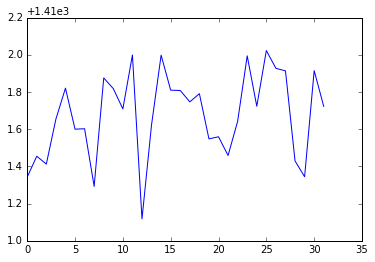

In [120]:
plot(np.abs(meas.s21_raw).mean(1))

3.95779459442
3.9613231872
4.00509356418
4.32788018269
got bad packet
0.743240538686
0.265673421968
4.16276838976
2.45491989465


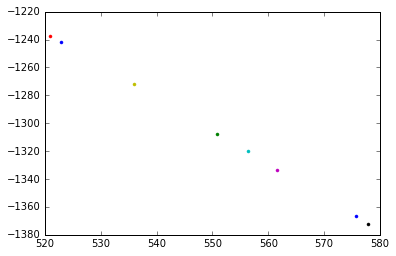

In [122]:
for k in range(8):
    ri.set_tone_freqs(low_group+1,nsamp=nsamp)
    ri.phases=None
    ri.set_tone_freqs(low_group,nsamp=nsamp)
    ri.select_fft_bins(range(32))
    ri._sync()
    meas = ri.get_measurement(0.2,demod=False)
    print ri.phases[3]
    #plot_ri(meas.s21_raw[3,:].mean(),'o')
    
    plot_ri(meas.s21_raw[3,:].mean()*np.exp(-1j*ri.phases[3]),'.')
#    plot(k,np.mod(np.angle(meas.s21_raw[3,:].mean())-ri.phases[3],2*np.pi),'.')

In [84]:
meas.s21_raw.dtype

dtype('complex64')

In [88]:
ri.phases

array([ 1.09330595,  1.18112487,  2.66701679,  0.02614463,  2.87692968,
        0.9577549 ,  5.78497351,  2.06547121,  2.42045547,  2.51654903,
        6.09688942,  5.23093864,  2.84906998,  5.73376217,  3.09920198,
        5.3480101 ,  5.71728711,  5.35622995,  3.42224892,  2.25864379,
        3.43848066,  2.07394199,  3.94779782,  1.98562729,  0.38614691,
        0.05488682,  0.70687581,  3.3220785 ,  4.05385946,  4.1348855 ,
        5.52497782,  4.01813075])

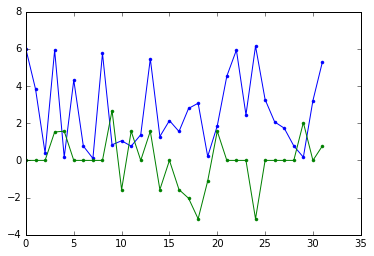

In [92]:
plot(ri.phases,'.-')
plot(-np.angle(meas.s21_raw.mean(1)),'.-')

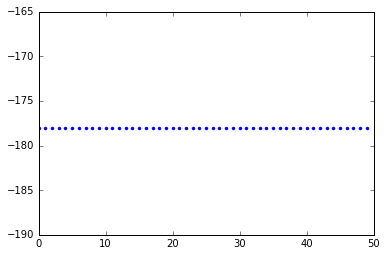

In [109]:
plot(meas.s21_raw[3,:50],'.')

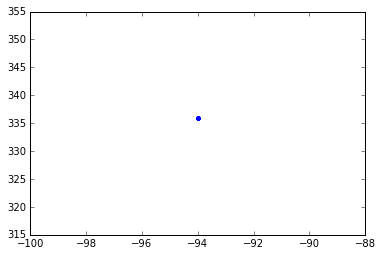

In [69]:
plot_ri(meas.s21_raw[3,:],'.')
#plot_ri(meas2.s21_raw[1,:],'.')
#plot_ri(meas3.s21_raw[1,:],'.')


In [65]:
d.shape

(16, 32)

In [30]:
ri.set_dac_atten(30)

In [57]:
x,y = ri.get_raw_adc()

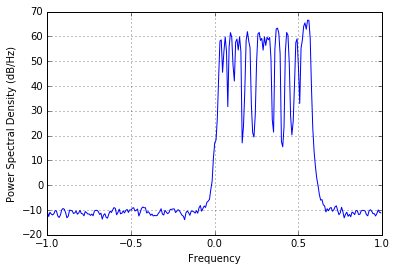

In [58]:
_=psd(x+1j*y)

In [59]:
x.std()

424.23299774354371

In [60]:
x.ptp()

2993.0

In [30]:
(20/2.5)**2

64.0